# Cart Pole solved with DQN using PyTorch

## install gym 

In [1]:
import utils 
from replaybuffer import ReplayBuffer
import torch 
import gymnasium as gym
import numpy as np 
import copy 
import matplotlib.pyplot as plt
%matplotlib inline

## Hyperparameters And constants

In [2]:
max_episodes= 5000
max_steps_in_episode=1000
learning_rate= 1e-3
gamma=0.995
max_replays=200000
batch_size=64
train_interval=3
tau= 1e-3 # used for soft update of target network after training. takes a fraction of the model's trained weights

layers=[64,64]
MSE = torch.nn.MSELoss()
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
memories=ReplayBuffer(max_replays, batch_size, device)

# Creating the environment

In [3]:
env = gym.make("CartPole-v1")

state_size = env.observation_space.shape
num_actions = env.action_space.n
Actions=np.arange(num_actions)
print(f'num_actions={num_actions}\n state_size={state_size} ')
env.reset()
env.render()

num_actions=2
 state_size=(4,) 


c:\Users\kailo\miniconda3\envs\torch\lib\site-packages\gymnasium\envs\classic_control\cartpole.py:215: UserWarning: WARN: You are calling render method without specifying any render mode. You can specify the render_mode at initialization, e.g. gym.make("CartPole-v1", render_mode="rgb_array")
  gym.logger.warn(


In [4]:
state = env.reset()
next, reward, done, _,_  = env.step(0)
print(f'state={state[0] }, next={next}, reward={reward}, done={done} ')

state=[ 0.0447919   0.00592917 -0.03987714  0.03600601], next=[ 0.04491048 -0.18859892 -0.03915701  0.3158454 ], reward=1.0, done=False 


### instantiating the deep Q networks

In [5]:
model=utils.DQN(state_size[0],  num_actions, layers)
target=copy.deepcopy(model) # target is a clone of the Q network 
opt=torch.optim.Adam(model.parameters(), lr=learning_rate)
target.eval() # target is not trained. Uses soft update to update its weights instead
model.train()
target.to(device)
model.to(device)

print(target)

DQN(
  (model): Sequential(
    (0): Linear(in_features=4, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=2, bias=True)
  )
)


## Exploration vs exploitation
### When training starts, exploration is favoured over exploitation. $\epsilon$ decays over training session to favour exploitation over exploration as model learns to take the right steps for each state.

In [6]:
epsilon=1.0 # starting epsilon
decay=0.995 # decay factor per episode

In [7]:
def getAction(dqnModel, epsilon, curState):
    model.eval()
    action=-1    
    if np.random.uniform(0,1) < max(0.05, epsilon) :
        action=np.random.choice(Actions) # randomly pick an action       
    else:
        action=utils.getQAction(dqnModel, state,device)
    return action

## Train the Q network

$$
\begin{equation}
    y_j =
    \begin{cases}
      R_j & \text{if episode terminates at step  } j+1\\
      R_j + \gamma \max_{a'}\hat{Q}(s_{j+1},a') & \text{otherwise}\\
    \end{cases}       
\end{equation}
$$

In [9]:
def trainDQN():
    model.train()
    states, actions, rewards, next_states, dones = memories.sample()

    with torch.no_grad():
        max_qsa=target(next_states)

    max_qsa, _=torch.max(max_qsa, dim=1)
    y_targets=rewards + gamma* max_qsa * (1. - dones)

    qsa=model(states)    
    vals=qsa.gather(1, actions.unsqueeze(1)).squeeze(1)
    opt.zero_grad()
    loss=MSE(y_targets, vals)
    loss.backward()
    opt.step()
    # soft update the target network 
    utils.softupdate(target, model, tau)
    

## Start collecting experiences and train the DQN

In [10]:
AverageRewards=[]
Rewards=0.
showRes=100
totalRewards=0. 
cnt=0

for ep in range (1, (max_episodes+1),1):
    state=env.reset()
    Rewards=0.
    epsilon*=decay
    for step in range(1, (max_steps_in_episode+1), 1):        
        cnt+=1        
        if step==1:
            state=state[0]
        action=getAction(model, epsilon, state)
        next, reward, done, _,_ = env.step(action)        
        # print(f'adding {state} , {action}, {reward},{next}, {done}')
        memories.add(state , action, reward,next, done)                                          
        
        Rewards+=reward
        if len(memories)> batch_size and cnt % train_interval==0:            
            trainDQN()
        state=next 
        if done or step ==max_steps_in_episode:
            break        
    print(f"\r episode: {ep} \t reward: {Rewards}", end="")
    totalRewards+=Rewards
    if ep % showRes==0:                  
        AverageRewards.append(totalRewards/showRes)     
        print(f'\r Episode:{ep} \t Average rewards= {AverageRewards[-1] } ') 
        totalRewards=0.  
        if AverageRewards[-1] > 500:
            print('\n\n training ends early ')
            break

 Episode:100 	 Average rewards= 18.03 
 Episode:200 	 Average rewards= 12.48 
 Episode:300 	 Average rewards= 10.77 
 Episode:400 	 Average rewards= 10.06 
 Episode:500 	 Average rewards= 10.8 
 Episode:600 	 Average rewards= 14.16 
 Episode:700 	 Average rewards= 63.7 
 Episode:800 	 Average rewards= 246.19 
 Episode:900 	 Average rewards= 210.63 
 Episode:1000 	 Average rewards= 197.32 
 Episode:1100 	 Average rewards= 153.05 
 Episode:1200 	 Average rewards= 164.51 
 Episode:1300 	 Average rewards= 160.27 
 Episode:1400 	 Average rewards= 166.66 
 Episode:1500 	 Average rewards= 172.14 
 Episode:1600 	 Average rewards= 174.15 
 Episode:1700 	 Average rewards= 192.35 
 Episode:1800 	 Average rewards= 258.17 
 Episode:1900 	 Average rewards= 367.29 
 Episode:2000 	 Average rewards= 800.14 


 training ends early 


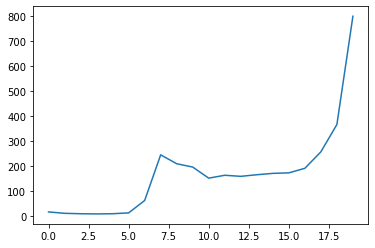

In [11]:
env.close()
plt.plot(AverageRewards)
plt.show()

In [12]:
# now we show the env 
env = gym.make("CartPole-v1", render_mode='human' )

In [14]:
utils.runDQNAgent(model, env, device, fps=50)
assert(False)

 rewards gaained: 332.00
Terminated with rewards=332.00


AssertionError: 

In [15]:
env.close()

## Save the trained model

In [ ]:
utils.saveTrainedModel(model, 'cartpole')

## load trained model to play

In [16]:
trainedModel= utils.DQN(state_size[0],  num_actions, layers)
utils.loadModel(trainedModel, "weights/cartpole")
print(trainedModel)
trainedModel.to(device)

DQN(
  (model): Sequential(
    (0): Linear(in_features=4, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=2, bias=True)
  )
)


DQN(
  (model): Sequential(
    (0): Linear(in_features=4, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=2, bias=True)
  )
)

###  run the trained agent 

In [17]:
env = gym.make("CartPole-v1", render_mode='human' )
utils.runDQNAgent(trainedModel, env, device, fps=50)

 rewards gaained: 1334.00

KeyboardInterrupt: 

In [18]:
env.close()